# ABOUT


Datascientest's Datascientist continuous bootcamp - cohorte Mars2022 -  AeroBOT project

**Tutor**

* Alban THUET

**Authors:**

* [Ioannis STASINOPOULOS](https://www.linkedin.com/in/ioannis-stasinopoulos/)

</br>

---
</br>

**Version History**

Version | Date       | Author(s)  | Modification
--------|----------- | ---------  | --------------------------
3.0     | 02/11/2022 | H.A.       | Code cleaning : keep only wordembedding 
2.1     | 28/09/2022 | H.A., I.S. | Use df_for_Anomaly_prediction.pkl as data source 
2.0     | 13/09/2022 | H.A., I.S. | Add WordEmbedding 1vsAll code 
1.1     | 29/07/2022 | H.A.       | Compilation of all BOW models 
1.0     | 24/07/2022 | I.S, H.A.  | Document creation

This notebook can be executed entirely. 

It

* mounts the GDrive of our AeroBot project @gmail account.

* loads the data from the `df_for_Anomaly_prediction.pkl` file (cf. `04_1_1 Anomaly feature Definition TRAIN set.ipynb`) under a pandas DataFrame named `df`, which contains `96986` entries and 20 columns.
These data do not contain any more UAS-related entries.

* Performs Anomaly target feature prediction : First WordEmbedding approach

# IMPORT PACKAGES


In [1]:
#######################
# Import packages
#######################
import numpy as np
import seaborn as sns
import math # for math.pi etc.
import time # time code execution

#######################
# Pandas
#######################
import pandas as pd
# Set pandas settings to show all data when using .head(), .columns etc.
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option("display.colheader_justify","left") # left-justify the print output of pandas

### Display full columnwidth
# Set pandas settings to display full text columns
#pd.options.display.max_colwidth = None
# Restore pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

import itertools # Pour créer des iterateurs

# Package to show the progression of pandas operations
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
# simply use .progress_apply() instead of .apply() on your pd.DataFram

######################
# PLOTTING
######################
import matplotlib.pyplot as plt
%matplotlib inline
# # Define global plot parameters for better readability and consistency among plots
# # A complete list of the rcParams keys can be retrieved via plt.rcParams.keys() function
# plt.rcParams['axes.titlesize'] = 30
# plt.rcParams['axes.labelsize'] = 23
# plt.rcParams['xtick.labelsize'] = 23
# plt.rcParams['ytick.labelsize'] = 23
# plt.rc('legend', fontsize=23)    # legend fontsize

# BOKEH 
from bokeh.plotting import figure # Importation de la classe figure qui permet de créer un graphique bokeh.
from bokeh.io import  push_notebook, output_notebook, show
output_notebook() # permet d'afficher tous les futurs graphiques dans l'output d'une cellule jupyter. Si cette instruction n'est pas lancée, la figure s'affichera dans un nouvel onglet.
from bokeh.models import ColumnDataSource, Label
from bokeh.transform import dodge
from bokeh.models.tools import HoverTool

###############################
# ML preprocessing and models
###############################
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble # random forest
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix

###############################
# Deep Learning
###############################
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras import callbacks


###############################
# Other
###############################
import pickle as pkl # Saving data externally

# DEFINE FUNCTIONS


In [2]:
def plot_train_history(training_history, metric, anomaly_name):
  """
  Generete plots to monitor the train process
  Inputs: 
  - 'training_history'; use training_history = model.train(...)
  - 'metric' to plot; string e.g. 'accuracy', 'loss'
  - 'anomaly_name' e.g. 'Anomaly_Conflict'. This is used for the plot title
  """
  fig = plt.figure(figsize = (10,4))
  #plt.title(f"{anomaly_name} train history - {metric.upper()}", fontsize = 20)
  train_acc = training_history.history[metric]
  val_acc = training_history.history['val_' + metric] # e.g. 'val_accuracy'

  plt.plot(train_acc, label = f'Training {metric}')
  plt.plot(val_acc, label = f'Validation {metric}')
  plt.xlabel('epochs')
  plt.ylabel(f'{metric}')
  plt.legend()
  plt.show();

# LOAD DATA

## Mount GDrive

In [3]:
#@title
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive/')

#check your present working directory 
%pwd

Mounted at /content/drive/


'/content'

In [4]:
#@title
# move to the transformed data location (you can create a deeper structure, if needed, e.g. to save a trained model):
%cd /content/drive/MyDrive/data/transformed/

/content/drive/MyDrive/data/transformed


In [5]:
#@title
!ls # list the content of the pwd

#!ls "/content/drive/MyDrive/Data_Science/Formations/DataScienceTest/projet/AeroBot/" # list contect of a speficic folder

 complaints-2022-08-05_13_55.csv
'Copy of Qualified abbreviations_20220718.xlsx.gsheet'
'Data Dictionnary.xlsx'
 data_for_BERT_multilabel_20220805.pkl
 df_for_Anomaly_prediction.pkl
 df_test_for_Anomaly_prediction.pkl
 model.png
 model_results
 Narrative_PP_stemmed_24072022_TRAIN.pkl
 Narrative_Raw_Stemmed_24072022_TRAIN.pkl
 Narrative_RegEx_subst_21072022_TRAIN.pkl
'Qualified abbreviations_20220707_test.csv'
'Qualified abbreviations_20220708.csv'
'Qualified abbreviations_20220718.csv'
'Qualified abbreviations_20220718_Google_sheet.gsheet'
 test_data_final.pkl
 train_data_final.pkl


## Load data from .pkl file


In [6]:
# Load the TRAIN data (97417 entries)
# Do not touch the TEST data until the end of the project!
# or the curse of the greek gods will fall upon you!

%cd /content/drive/MyDrive/data/transformed/
with open("df_for_Anomaly_prediction.pkl", "rb") as f:
    loaded_data = pkl.load(f)

df = loaded_data
print("\nA Dataframe with", len(df), "entries has been loaded")

/content/drive/MyDrive/data/transformed

A Dataframe with 96986 entries has been loaded


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96986 entries, 1163382 to 874642
Data columns (total 20 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   Narrative                                     96986 non-null  object
 1   Anomaly                                       96986 non-null  object
 2   Narrative_PP_stemmed                          96986 non-null  object
 3   Narrative_Raw_Stemmed                         96986 non-null  object
 4   Narrative_Raw_Stemmed_str                     96986 non-null  object
 5   Narrative_PP_stemmed_str                      96986 non-null  object
 6   Anomaly_Deviation / Discrepancy - Procedural  96986 non-null  int64 
 7   Anomaly_Aircraft Equipment                    96986 non-null  int64 
 8   Anomaly_Conflict                              96986 non-null  int64 
 9   Anomaly_Inflight Event / Encounter            96986 non-null  int

## Define Anomaly_RootLabels_columns list from data set

In [8]:
# Retriece the list of Anomaly label columns
Anomaly_RootLabels_columns = []

for col in df.columns:
  if 'Anomaly_' in str(col):
      Anomaly_RootLabels_columns.append(col)

In [9]:
Anomaly_RootLabels_columns

['Anomaly_Deviation / Discrepancy - Procedural',
 'Anomaly_Aircraft Equipment',
 'Anomaly_Conflict',
 'Anomaly_Inflight Event / Encounter',
 'Anomaly_ATC Issue',
 'Anomaly_Deviation - Altitude',
 'Anomaly_Deviation - Track / Heading',
 'Anomaly_Ground Event / Encounter',
 'Anomaly_Flight Deck / Cabin / Aircraft Event',
 'Anomaly_Ground Incursion',
 'Anomaly_Airspace Violation',
 'Anomaly_Deviation - Speed',
 'Anomaly_Ground Excursion',
 'Anomaly_No Specific Anomaly Occurred']

# PREDICTION

## WordEmbedding 1vs.All - First attempt

In [10]:
def word_embedding_clf(data, target, maxlen, num_words, N_emb): 
  """
  Perform binary classification using WordEmbedding

  Inputs:
  - data as pd.Series, narrative strings, e.g. df['Narrative_PP_stemmed_str']
  - target as pd.Series, e.g. df['Anomaly_Conflict']
  - maxlen (int) : length of the text vector (in words). Will ignore narrative content beyond this limit
  - num_words (int): desired vocab size; only the most common words are kept
  - N_emb (int) = 200: Dimension of embedding (# columns of the embedding matrix)
    # reducing this from 200 to 100 improved the f1-score of '1' from 0.85 to 0.87 !
    # reducing to 50 did not improve the f1 further


  Returns:
  - training history
  - 'metrics': pd.Dataframe containing the classification report content
  """ 

  # Time the function execution
  start_time = time.time()
  anomaly_name = target.name
  print(7*'-', f"Execution started for label '{anomaly_name}' ...", 7*'-')

  # One-hot encode target
  target = keras.utils.to_categorical(target) 
  # Train-test split  
  X_text_train, X_text_test, y_train, y_test = train_test_split(data, target, 
                                                      test_size= 0.2,
                                                      random_state = 12) 

  ###############################
  # TOKENIZE
  from keras.preprocessing.text import Tokenizer

  tokenizer = Tokenizer(num_words = num_words, # only the most common words are kept
                        oov_token = 'OOV'
                        ) 
  tokenizer.fit_on_texts(X_text_train) # Updates internal vocabulary based on a list of texts

  # Save the dictionary of correspondence between words and indices
  word2idx = tokenizer.word_index
  # Save the dictionary of correspondence between indices and words
  idx2word = tokenizer.index_word
  # Save the vocab size
  vocab_size = tokenizer.num_words  
  print('Tokenization completed.')
  print(f'Vocabulary size: {vocab_size} (user-defined)\n')
  example_OOV = word2idx['OOV']
  print(f"Example: index of 'OOV': {example_OOV} (Out-Of-Vocabulary label; user-defined)")
  example_aircraft = word2idx['aircraft']
  print(f"Example: index of 'aircraft': {example_aircraft}\n")
  print(30*"-")

  ###############################
  # VECTORIZE NARRATIVES
  # Map each text into a sequence of integers (word indices)
  # We use the vocab obtained from training on the X_text_train data to vectorize both the train and test data
  # Transform every review into a sequence of integers (indices of the vocab)
  X_train = tokenizer.texts_to_sequences(X_text_train)
  X_test = tokenizer.texts_to_sequences(X_text_test)
  print('Vectorization completed.')
  rnd_idx = np.random.randint(len(X_train), size = 2)
  for idx in rnd_idx:
    print(f'Random examples of entries in X_train:\n {X_train[idx]}')
    print(f'Length: {len(X_train[idx])}\n')
  print(30*"-")

  # Pad & truncate train and test sequences (texts transformed in numeric sequences) to make them of the same length
  X_train = keras.preprocessing.sequence.pad_sequences(X_train, # Liste des textes transformés en index
                                                          maxlen = maxlen, # Nombre maximal de mots dans un texte. See length analysis above
                                                          padding = 'post', # pad either before or after each sequence
                                                          truncating = 'post', # truncate either before or after each sequence
                                                          value=0.0) # with what to pad
  # if maxlen is not provided, uses the length of the longest sequence in the list.
  X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen = maxlen, padding = 'post', truncating= 'post')
  print('Sequence padding / truncating completed.\n')
  print(f'Each entry in X_train has length: {maxlen} (user-defined)\n')
  
  for idx in rnd_idx:
    print(f"Entries in X_train now look like this (observe the presence of '1', corresponding to 'OOV'):\n\n {X_train[idx]}\n")
  print(30*"-")  

  ###############################
  # BUILD THE MODEL
  keras.backend.clear_session()
  # Keras starts with a blank state at each iteration and memory consumption is constant over time.
  
  model = Sequential(name = "Word_Embedding_model") # does not accept spaces
  model.add(Embedding(input_dim = vocab_size, output_dim = N_emb)) # The embedding matrix is a *trainable* parameter
  model.add(GlobalAveragePooling1D()) # no parameters to tune; it's an advantage of GlobalAveragePooling1D
  # Use global average pooling blocks as an alternative to a Flatten() layer 

  model.add(Dense(units = 32, activation = 'relu'))
  model.add(Dropout(rate = 0.3)) # prevents overfitting
  model.add(Dense(units = 2, activation = 'sigmoid')) # 2 units, because BINARY classification problem
  # 'sigmoid' activation because binary classification
  print(model.summary())

  ###############################   
  # Define CALLBACKS
  TON = callbacks.TerminateOnNaN() # Callback that terminates training when a NaN loss is encountered

  early_stopping = callbacks.EarlyStopping(monitor = 'binary_accuracy', # 'binary_accuracy' calculates how often predictions match binary labels.
                                          min_delta=0.01,
                                          patience = 7, 
                                          mode = 'max', 
                                          restore_best_weights = True, 
                                          verbose = 1)

  lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'binary_accuracy',
                                          patience = 3, 
                                          verbose = 1, # nombre d'informations qui seront affichées durant l'apprentissage
                                          min_delta=0.01,
                                          mode = 'max')
  ###############################
  # Compile and FIT the model
  opt = keras.optimizers.Adam(#learning_rate = 0.0001 # default learning_rate = 0.001
                              ) 
  model.compile(optimizer = opt, 
                loss = 'binary_crossentropy', 
                metrics = ['accuracy', 'binary_accuracy', 'binary_crossentropy']) # see https://keras.io/api/metrics/

  training_history = model.fit(
            X_train, y_train,
            validation_split = 0.2,
            epochs = 50, # very high number; callbacks will stop it earlier anyway
            batch_size = 32, # the higher, the faster one epoch is completed
            callbacks = [TON, early_stopping, lr_plateau
                         ],
            verbose = True)
  
  ###############################
  # Plot the train history
  plot_train_history(training_history, 'accuracy', anomaly_name)
  plot_train_history(training_history, 'loss', anomaly_name)

  ###############################
  # EVALUATE
  y_pred = model.predict(X_test, batch_size=32, verbose=1)
  y_pred_bool = np.argmax(y_pred, axis=1)
  y_test_bool = np.argmax(y_test, axis=1)

  print(f"\n\n Classification Report for label '{anomaly_name}': \n {classification_report(y_test_bool, y_pred_bool)}\n")

  ###############################
  # EXPORT CLASSIFICATION REPORT

  # Classif. report; dict format
  clf_rep = classification_report(y_test_bool, y_pred_bool, output_dict = True)
  # write classification report dictionnary into pd.DataFrame
  metrics = pd.DataFrame(clf_rep).reset_index().rename(columns = {'index': 'metric'})
  # Fill in with anomaly name
  metrics['anomaly'] = anomaly_name
  # Fill in additionnal columns with metadata
  metrics['classifier'] = 'Word_Embedding'  # [dt, rf, Word_Embedding, ...]
  metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
  metrics['undersampling'] = 0              # 1 if undersampling was applied
  metrics['Count_Vectorizer_opts'] = np.nan # ['exclude_numerics'; 'min_df = 12'; ...]
  # Reorder columns
  metrics = metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                     'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]
  
  # Calculate and print time to execute
  print(7*'-', f"Execution finished for label '{anomaly_name}' !", 7*'-')
  end_time = time.time()
  print(f"--- It took {np.round((end_time - start_time)/60,1)} minutes --- \n\n")

  return training_history, metrics

### Test on 1 Anomaly label

------- Execution started for label 'Anomaly_Conflict' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [2, 103, 123, 5, 1001, 270, 78, 142, 24, 77, 950, 1471, 1834, 32, 3, 227, 374, 79, 1041, 24, 155, 44, 42, 18, 210, 40, 29, 101, 916, 29, 58, 42, 24, 268, 537, 253, 146, 2, 937, 51, 3, 2, 778, 153, 27, 1001, 716, 4, 20, 24, 232, 94, 592, 19, 146, 2, 88, 153, 1008, 146, 153, 1, 24, 135, 618, 446, 230, 223, 19, 37, 1, 2, 136, 235, 185, 486, 537, 1023, 114, 323, 24, 318, 1298, 3, 56, 6, 219, 101, 99, 1, 2464, 19, 37, 1, 24, 131, 537, 722, 552, 131, 2, 1150, 189, 79, 497, 212, 3, 344, 80, 535, 24, 588, 137, 2, 245, 1, 1523, 245, 80, 1832, 2, 186, 99, 24, 88, 375, 36, 533, 36, 1288, 528, 1, 911, 169, 328, 2, 24, 77, 25, 50, 961, 408]
Length: 142

Random examples of entries

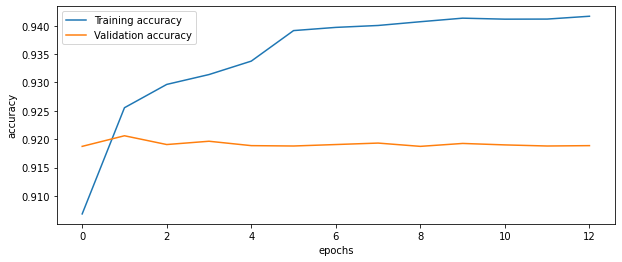

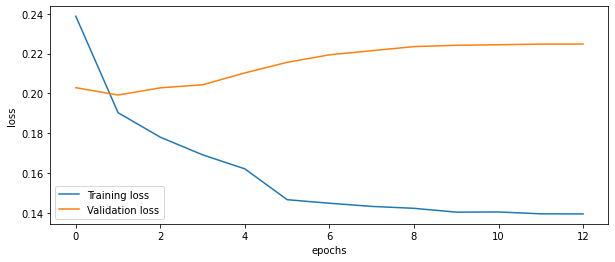

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_Conflict': 
               precision    recall  f1-score   support

           0       0.94      0.97      0.95     15934
           1       0.83      0.69      0.75      3464

    accuracy                           0.92     19398
   macro avg       0.88      0.83      0.85     19398
weighted avg       0.92      0.92      0.92     19398


------- Execution finished for label 'Anomaly_Conflict' ! -------
--- It took 2.5 minutes --- 




In [11]:
# Test: Call the function on ONE anomaly label
training_history, metrics = word_embedding_clf(df['Narrative_PP_stemmed_str'], 
                                               df['Anomaly_Conflict'],
                                               maxlen = 200, 
                                               num_words = 3000, 
                                               N_emb = 200)

### Loop through all anomalies

------- Execution started for label 'Anomaly_Deviation / Discrepancy - Procedural' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [317, 671, 720, 6, 80, 51, 44, 3, 3, 28, 91, 911, 556, 197, 174, 63, 109, 417, 533, 807, 109, 5, 8, 197, 174, 63, 309, 1, 197, 174, 63, 194, 109, 417, 746, 539, 54, 1122, 82, 482, 737, 109, 417, 291, 1394, 287, 278, 112, 29, 2171, 100, 103, 28, 5, 321, 75, 163, 267, 51, 6, 244, 80, 840, 76, 2452, 6, 273, 6, 226, 1267, 55, 90, 1, 1, 119, 344, 80, 1, 450, 1698, 506, 51, 6, 137, 450, 1, 86, 417, 889, 2231, 390, 137, 1211, 226, 1267, 35, 12, 239, 32, 95, 11, 95, 449, 1238, 912, 231, 109, 290, 746, 1, 515, 95]
Length: 112

Random examples of entries in X_train:
 [141, 6, 30, 13, 96, 625, 226, 72, 7, 55, 54, 417, 109, 291, 55, 99, 85, 660, 234, 

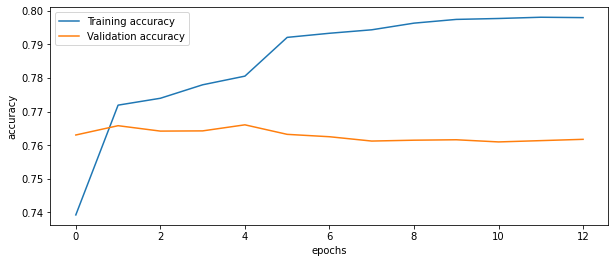

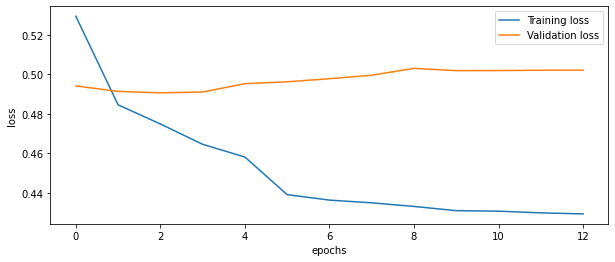

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_Deviation / Discrepancy - Procedural': 
               precision    recall  f1-score   support

           0       0.72      0.65      0.68      7747
           1       0.78      0.83      0.81     11651

    accuracy                           0.76     19398
   macro avg       0.75      0.74      0.74     19398
weighted avg       0.76      0.76      0.76     19398


------- Execution finished for label 'Anomaly_Deviation / Discrepancy - Procedural' ! -------
--- It took 2.7 minutes --- 


------- Execution started for label 'Anomaly_Aircraft Equipment' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [76, 1241, 159, 14, 2, 47, 44, 3, 3, 84, 427, 1, 5, 105, 191, 1, 357, 29

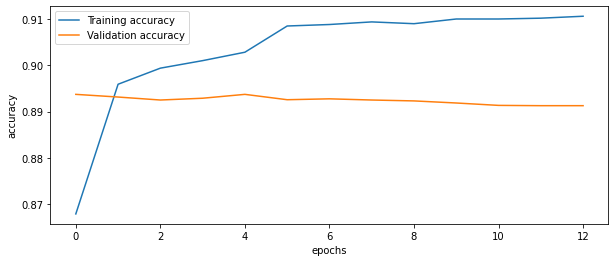

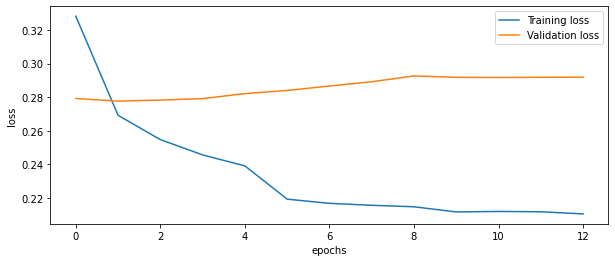

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_Aircraft Equipment': 
               precision    recall  f1-score   support

           0       0.92      0.90      0.91     11732
           1       0.85      0.88      0.86      7666

    accuracy                           0.89     19398
   macro avg       0.88      0.89      0.89     19398
weighted avg       0.89      0.89      0.89     19398


------- Execution finished for label 'Anomaly_Aircraft Equipment' ! -------
--- It took 2.6 minutes --- 


------- Execution started for label 'Anomaly_Conflict' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [38, 460, 466, 1040, 877, 22, 210, 129, 206, 745, 7, 250, 91, 780, 1023, 146, 780, 241, 230, 61, 438, 206, 745, 7, 14,

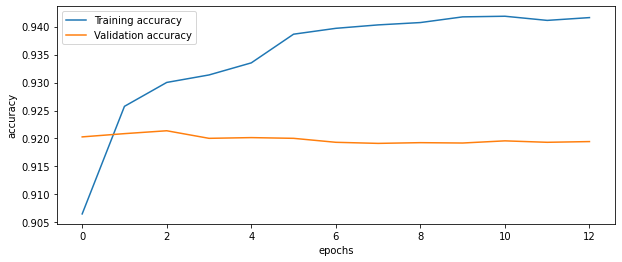

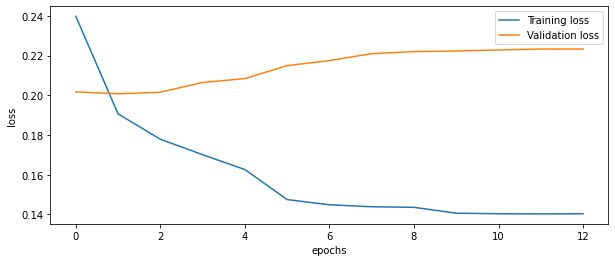

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_Conflict': 
               precision    recall  f1-score   support

           0       0.94      0.97      0.95     15934
           1       0.82      0.71      0.76      3464

    accuracy                           0.92     19398
   macro avg       0.88      0.84      0.86     19398
weighted avg       0.92      0.92      0.92     19398


------- Execution finished for label 'Anomaly_Conflict' ! -------
--- It took 2.4 minutes --- 


------- Execution started for label 'Anomaly_Inflight Event / Encounter' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [207, 264, 3, 3, 206, 2238, 11, 134, 202, 8, 26, 9, 228, 227, 9, 171, 1282, 139, 151, 232, 11, 2581, 70, 14, 420, 171, 3

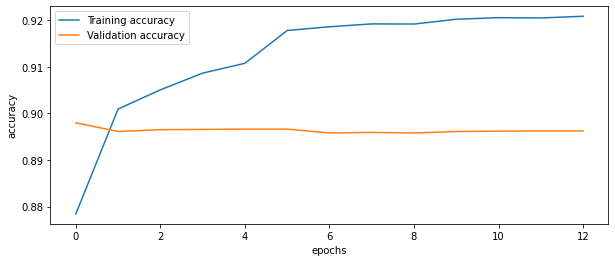

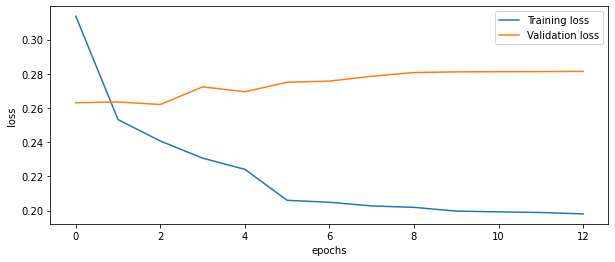

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_Inflight Event / Encounter': 
               precision    recall  f1-score   support

           0       0.92      0.96      0.94     15963
           1       0.77      0.60      0.67      3435

    accuracy                           0.90     19398
   macro avg       0.84      0.78      0.80     19398
weighted avg       0.89      0.90      0.89     19398


------- Execution finished for label 'Anomaly_Inflight Event / Encounter' ! -------
--- It took 2.6 minutes --- 


------- Execution started for label 'Anomaly_ATC Issue' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [458, 322, 2046, 322, 435, 229, 76, 69, 1236, 78, 779, 108, 229, 52, 1106, 15, 19, 52, 15, 19, 52, 65

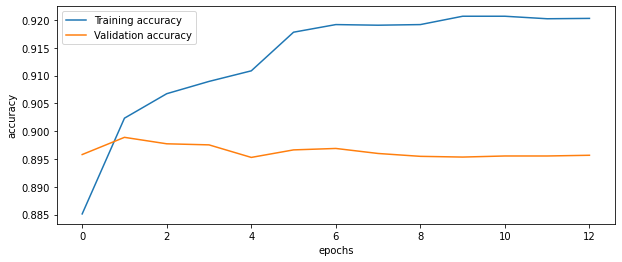

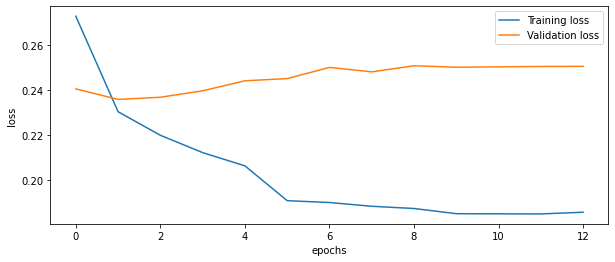

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_ATC Issue': 
               precision    recall  f1-score   support

           0       0.92      0.96      0.94     16233
           1       0.74      0.57      0.65      3165

    accuracy                           0.90     19398
   macro avg       0.83      0.77      0.79     19398
weighted avg       0.89      0.90      0.89     19398


------- Execution finished for label 'Anomaly_ATC Issue' ! -------
--- It took 2.5 minutes --- 


------- Execution started for label 'Anomaly_Deviation - Altitude' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [40, 108, 2644, 1951, 8, 53, 40, 814, 1650, 2933, 40, 91, 224, 17, 2, 47, 14, 28, 248, 1, 2744, 503, 27, 248, 525, 1990, 267

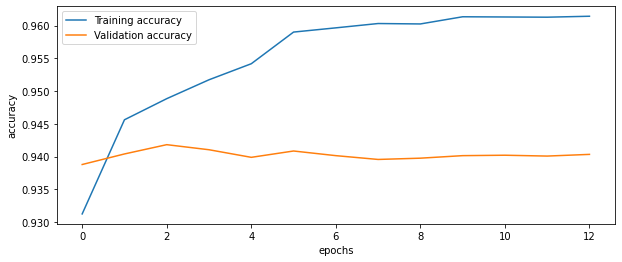

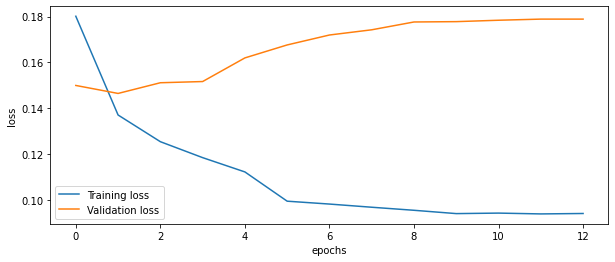

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_Deviation - Altitude': 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     17666
           1       0.74      0.59      0.65      1732

    accuracy                           0.94     19398
   macro avg       0.85      0.78      0.81     19398
weighted avg       0.94      0.94      0.94     19398


------- Execution finished for label 'Anomaly_Deviation - Altitude' ! -------
--- It took 2.6 minutes --- 


------- Execution started for label 'Anomaly_Deviation - Track / Heading' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [644, 30, 247, 405, 7, 1, 30, 163, 97, 7, 3, 1202, 17, 206, 30, 499, 97, 77, 1, 605, 14, 97, 7,

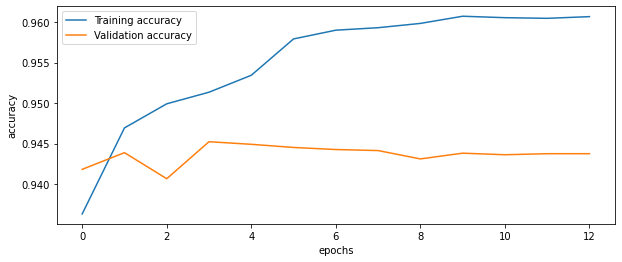

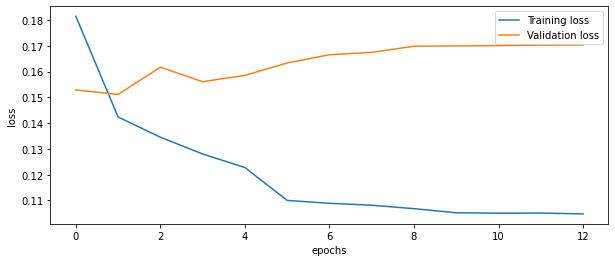

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_Deviation - Track / Heading': 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     17788
           1       0.73      0.52      0.61      1610

    accuracy                           0.94     19398
   macro avg       0.85      0.75      0.79     19398
weighted avg       0.94      0.94      0.94     19398


------- Execution finished for label 'Anomaly_Deviation - Track / Heading' ! -------
--- It took 2.6 minutes --- 


------- Execution started for label 'Anomaly_Ground Event / Encounter' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [92, 4, 197, 365, 174, 201, 1, 197, 365, 174, 63, 794, 1341, 15, 19, 365, 746, 963, 

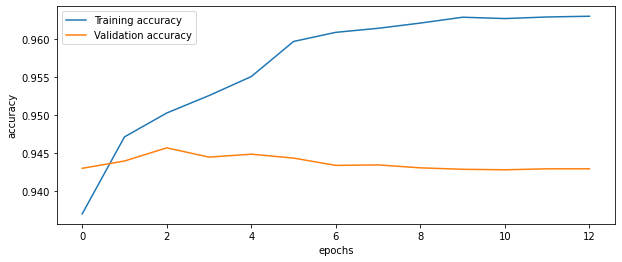

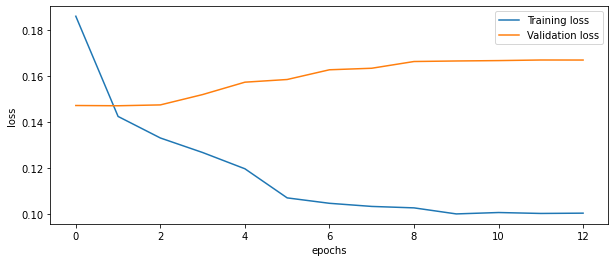

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_Ground Event / Encounter': 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     17914
           1       0.67      0.49      0.57      1484

    accuracy                           0.94     19398
   macro avg       0.81      0.74      0.77     19398
weighted avg       0.94      0.94      0.94     19398


------- Execution finished for label 'Anomaly_Ground Event / Encounter' ! -------
--- It took 2.5 minutes --- 


------- Execution started for label 'Anomaly_Flight Deck / Cabin / Aircraft Event' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [33, 303, 192, 182, 2081, 2, 47, 443, 443, 176, 1274, 502, 12, 254, 744, 104, 

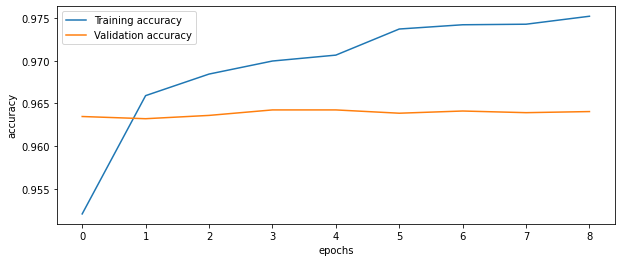

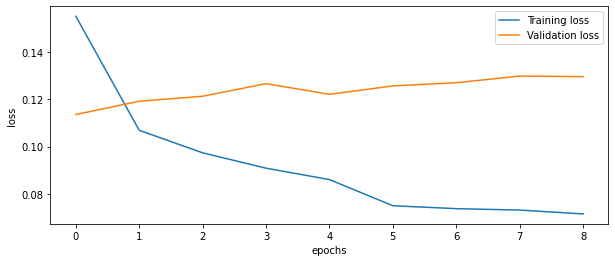

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_Flight Deck / Cabin / Aircraft Event': 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     17883
           1       0.88      0.56      0.68      1515

    accuracy                           0.96     19398
   macro avg       0.92      0.77      0.83     19398
weighted avg       0.96      0.96      0.95     19398


------- Execution finished for label 'Anomaly_Flight Deck / Cabin / Aircraft Event' ! -------
--- It took 2.7 minutes --- 


------- Execution started for label 'Anomaly_Ground Incursion' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [74, 1155, 851, 34, 33, 388, 392, 2, 208, 1032, 617, 937, 819, 433, 178, 8

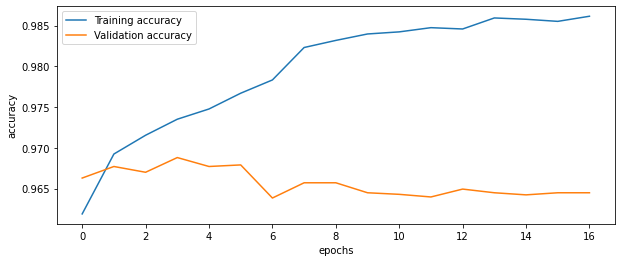

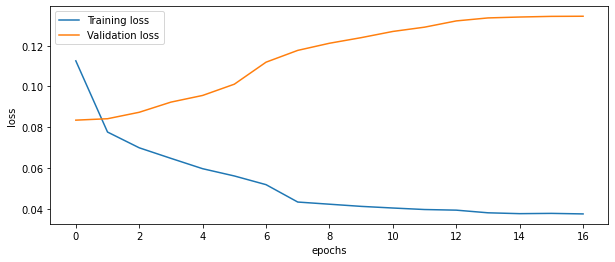

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_Ground Incursion': 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     18322
           1       0.67      0.63      0.65      1076

    accuracy                           0.96     19398
   macro avg       0.83      0.81      0.82     19398
weighted avg       0.96      0.96      0.96     19398


------- Execution finished for label 'Anomaly_Ground Incursion' ! -------
--- It took 3.6 minutes --- 


------- Execution started for label 'Anomaly_Airspace Violation' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [1, 14, 1907, 25, 301, 20, 785, 4, 267, 1280, 4, 317, 125, 78, 2, 626, 933, 22, 84, 304, 2, 110, 1456, 253, 2989

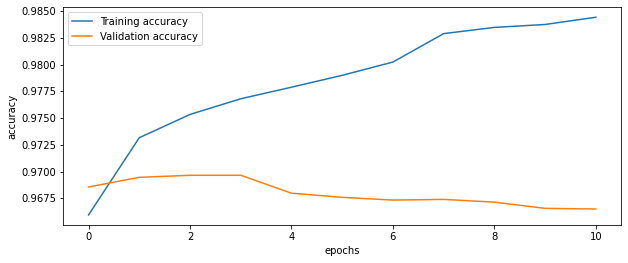

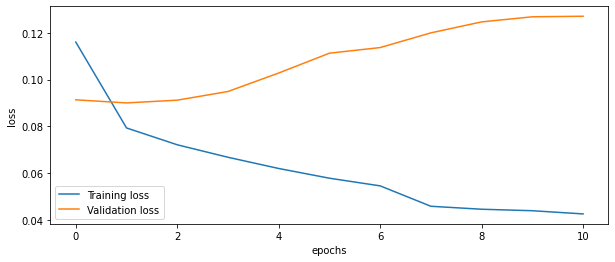

607/607 [==============================] - 1s 2ms/step


 Classification Report for label 'Anomaly_Airspace Violation': 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     18594
           1       0.76      0.50      0.60       804

    accuracy                           0.97     19398
   macro avg       0.87      0.75      0.79     19398
weighted avg       0.97      0.97      0.97     19398


------- Execution finished for label 'Anomaly_Airspace Violation' ! -------
--- It took 2.2 minutes --- 


------- Execution started for label 'Anomaly_Deviation - Speed' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [14, 97, 7, 134, 202, 3, 98, 14, 6, 18, 63, 673, 19, 24, 134, 285, 3, 98, 81, 18, 62, 1192, 107, 9, 382, 251,

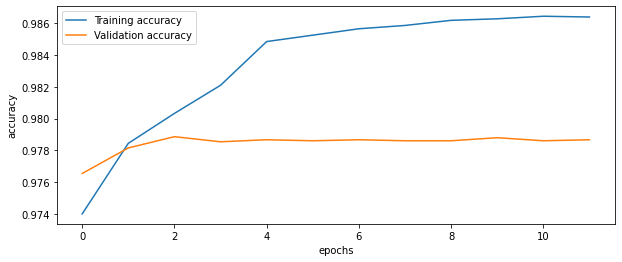

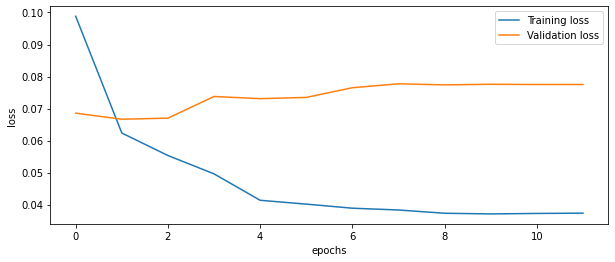

607/607 [==============================] - 1s 2ms/step


 Classification Report for label 'Anomaly_Deviation - Speed': 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     18873
           1       0.60      0.41      0.49       525

    accuracy                           0.98     19398
   macro avg       0.79      0.70      0.74     19398
weighted avg       0.97      0.98      0.97     19398


------- Execution finished for label 'Anomaly_Deviation - Speed' ! -------
--- It took 2.4 minutes --- 


------- Execution started for label 'Anomaly_Ground Excursion' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [756, 497, 2463, 1, 229, 150, 776, 284, 33, 229, 150, 61, 33, 108, 1, 1, 25, 709, 1, 231, 967, 1, 1055, 500, 385

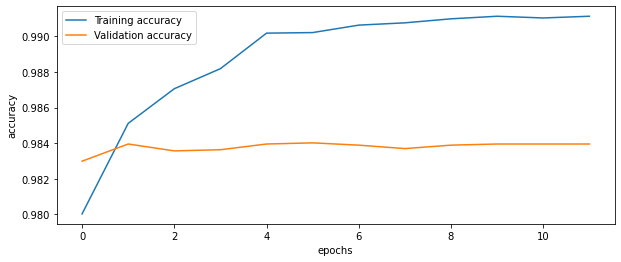

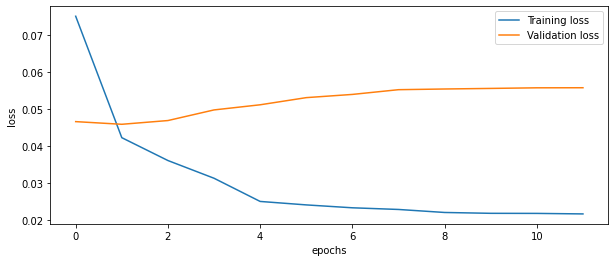

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_Ground Excursion': 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     18961
           1       0.69      0.59      0.64       437

    accuracy                           0.98     19398
   macro avg       0.84      0.79      0.82     19398
weighted avg       0.98      0.98      0.98     19398


------- Execution finished for label 'Anomaly_Ground Excursion' ! -------
--- It took 2.6 minutes --- 


------- Execution started for label 'Anomaly_No Specific Anomaly Occurred' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [1295, 7, 84, 9, 38, 97, 298, 1301, 1, 1, 73, 1, 1660, 549, 129, 2698, 1224, 3, 892, 59, 527, 38, 1660

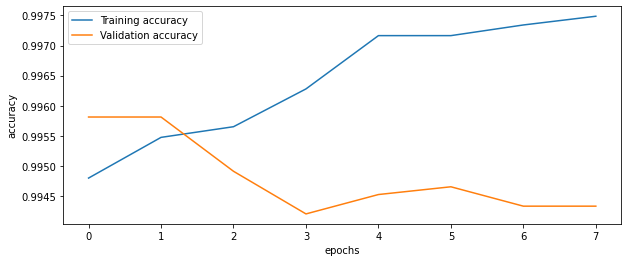

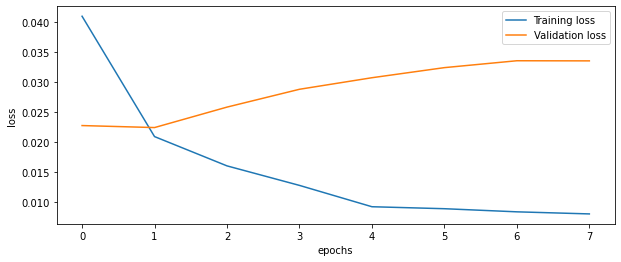

607/607 [==============================] - 1s 2ms/step


 Classification Report for label 'Anomaly_No Specific Anomaly Occurred': 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     19273
           1       0.00      0.00      0.00       125

    accuracy                           0.99     19398
   macro avg       0.50      0.50      0.50     19398
weighted avg       0.99      0.99      0.99     19398


------- Execution finished for label 'Anomaly_No Specific Anomaly Occurred' ! -------
--- It took 1.7 minutes --- 




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [14]:
# /!\ takes time to run!
# Call the function looping on ALL anomalies
# list of metrics DataFrames of our experiment
metrics_df_list = []

for anomaly in Anomaly_RootLabels_columns:
  training_history, metrics = word_embedding_clf(df['Narrative_PP_stemmed_str'], 
                                                 df[anomaly],    
                                                 maxlen = 200, 
                                                 num_words = 3000, 
                                                 N_emb = 200)
  metrics_df_list.append(metrics)

metrics_exp = pd.concat(metrics_df_list)
# Reset index, otherwise you get a repetition of 0,1,2,3
metrics_exp = metrics_exp.reset_index().drop(columns =['index'])

In [15]:
# # save the df externally
# ##########################################################
# # WARNING!! 
# # If you execute this cell, you will OVERWRITTE the data!
# ##########################################################

# %cd /content/drive/MyDrive/data/transformed/model_results/

# with open("metrics_WordEmbedding_20220727_2200.pkl", "wb") as f:
#     pkl.dump([metrics_exp], f) # saves the variables into a list